# Project 2

## Summary of Project

# Hypothesis or A/B Testing

## Three Tests
1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Does employee territory have a statistically significant effect on total sales
3. Does an employees age have a statistically signifiant effect on order totals
4. Do regions have a statistically significant effect on discounts

In [66]:
#import libraries and functions
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
%matplotlib inline

In [4]:
#get sql database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [5]:
#function to pull sql queries and return a pandas table
def query_to_df(query):
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    return df

In [6]:
#query 1
#Need Discount & Quantity from OrderDetail table
query1 = """SELECT Discount, Quantity
            FROM OrderDetail;"""
df1 = query_to_df(query1)

In [7]:
df1.head()

,Discount,Quantity
0,0.0,12
1,0.0,10
2,0.0,5
3,0.0,9
4,0.0,40


In [8]:
df1.describe()

,Discount,Quantity
count,2155.000000,2155.000000
mean,0.056167,23.812993
std,0.083450,19.022047
min,0.000000,1.000000
25%,0.000000,10.000000
50%,0.000000,20.000000
75%,0.100000,30.000000
max,0.250000,130.000000


## Null Hypothesis:
There is no significant effect from discount on quantity of a product in an order

## Alternative Hypothesis:
There is a signifiant effect from discount on quantity of a product in an order

### Alpha (α) = 0.05
### Power = 80% or 0.80
### 

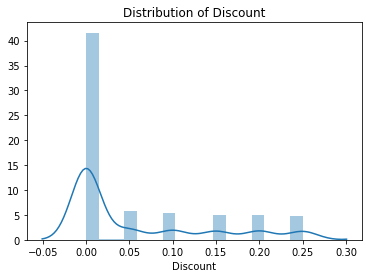

In [9]:
#seaborn distplot
sns.distplot(df1.Discount);
plt.title('Distribution of Discount');

### Observations of Discount
- Discount is an ordinal variable
- Most orders have a 0% discount
- Has a very long right tail

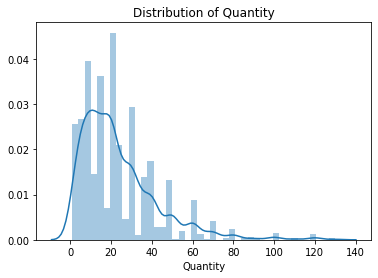

In [10]:
sns.distplot(df1.Quantity);
plt.title('Distribution of Quantity');

### Observations of Quantity (The dependant variable)
- Positively skewed
- Minimum value is 1, max value is 130
- The mean is around 20

## Next Steps
1. Set up control and experimental groups
    
    a. Control group has no discount  
    b. Experimental group has discounts
    
    
2. Create a Sample Distribution using the Sample Means
    
    a. Using Central Limit Theorem, the mean of the samples will be a normal distribution
    
    
3. Run Welch's T-Test

    a. Find the p-value between the control and experimental values

## Step 1: Set up Control and Experimental Groups

In [11]:
#statistical analysis 1
#make control group, discount = 0
control = df1[df1['Discount']==0]
control.describe()

,Discount,Quantity
count,1317.0,1317.000000
mean,0.0,21.715262
std,0.0,17.507493
min,0.0,1.000000
25%,0.0,10.000000
50%,0.0,18.000000
75%,0.0,30.000000
max,0.0,130.000000


In [12]:
#make experimental group, discount != 0
experimental = df1[df1['Discount']!=0]
experimental.describe()

,Discount,Quantity
count,838.000000,838.000000
mean,0.144439,27.109785
std,0.071808,20.771439
min,0.010000,1.000000
25%,0.100000,12.000000
50%,0.150000,20.000000
75%,0.200000,36.000000
max,0.250000,130.000000


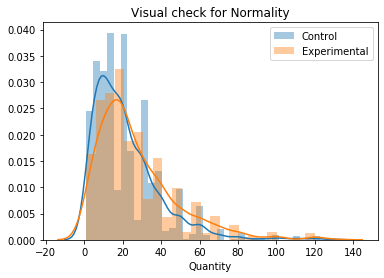

In [13]:
#Plot Control and Experimental to check for Normality
sns.distplot(control.Quantity, label='Control');
sns.distplot(experimental.Quantity, label='Experimental');
plt.title('Visual check for Normality');
plt.legend();

### Observations
1. Positively skewed
2. A lot of overlap

## Step 2: Create a Sample Distribution using the Sample Means

In [22]:
def find_s(a, b):
#a and b are arrays from the control and experimental group
#used to find the s in the denominator of cohen's d equatin to find effect size
    num = (len(a)-1)*(a.std())**2 + (len(b)-1)*(b.std())**2
    denom = len(a) + len(b)
    return np.sqrt(num/denom)

In [83]:
#Calculate what sample size is needed for Control and Experimental
def get_sample_size(alpha, power, a, b):
    power_analysis = TTestIndPower()
    alpha = 0.05
    power = 0.80
    mean_difference = abs(a.mean()-b.mean())
    s = find_s(a, b)
    effect_size = mean_difference / s
    sample_size = power_analysis.solve_power(alpha=.05, effect_size=effect_size, power=.80, alternative='larger')
    print("""Using alpha = {}, effect size = {}, and power = {}: 
             The sample size should be {}""".format(alpha, effect_size, power, sample_size))
    return int(np.round(sample_size) + 1)

In [103]:
sample_size = int(get_sample_size(0.05, 0.80, control.Quantity, experimental.Quantity))
sample_size

Using alpha = 0.05, effect size = 0.28641058366376687, and power = 0.8: 
             The sample size should be 151.41800022641124


152

In [50]:
#Create samples 10,000 times from control and experimental groups
def get_sample_means(a, sample_size, num_of_samples):
    #a is an array of values to sample from
    #sample_size is defined above using get_sample_size
    #num_of_samples is the number of samples to take
    sample_means = []
    for i in range(num_of_samples):
        sample = a.sample(sample_size)
        sample_means.append(sample.mean())
    return sample_means


num_of_samples = 10000
control_sample_means = get_sample_means(control.Quantity, sample_size, num_of_samples)
experimental_sample_means = get_sample_means(experimental.Quantity, sample_size, num_of_samples)

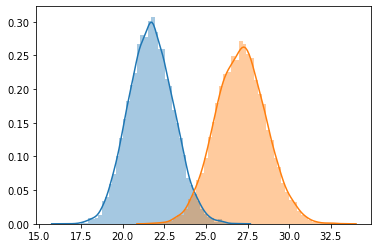

In [52]:
#With the sample mean values, graph control vs. experimental again.
sns.distplot(control_sample_means);
sns.distplot(experimental_sample_means);

In [ ]:
welchs_t_test_p_value = stats.ttest_ind(control_sample_means, experimental_sample_means, equal_var=False)[1]/2
print("Running Welch's T-Test gives a p-value of:",welchs_t_test_p_value)

In [71]:
#run anova test
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


In [101]:
#Break df into each discount amount
print(df1.Discount.value_counts())
#get rid of 0.03, 0.02, 0.01, 0.04, 0.06 since they only have 3 or less orders on them and they are unusual discounts
discount0 = df1[df1.Discount==0]
discount5 = df1[df1.Discount == 0.05]
discount10 = df1[df1.Discount == 0.1]
discount15 = df1[df1.Discount == 0.15]
discount20 = df1[df1.Discount == 0.2]
discount25 = df1[df1.Discount == 0.25]
discounts = [discount5, discount10, discount15, discount20, discount25]

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64


In [105]:
#make boxplots of each discount amount

In [104]:
samples = []
for discount in discounts:
    control_sample_means = get_sample_means(discount0.Quantity, sample_size, 10000)
    exp_sample_means = get_sample_means(discount.Quantity, sample_size, 10000)
    run_welchs_ttest(control_sample_means, exp_sample_means)

Running Welch's T-Test gives a p-value of: 0.0
Running Welch's T-Test gives a p-value of: 0.0
Running Welch's T-Test gives a p-value of: 0.0
Running Welch's T-Test gives a p-value of: 0.0
Running Welch's T-Test gives a p-value of: 0.0


In [86]:
#get samples of each level
sample_size = get_sample_size(0.05, 0.80, discount0.Quantity, discount5.Quantity)
control_sample_means = get_sample_means(discount0.Quantity, sample_size, 10000)
discount5_sample_means = get_sample_means(discount5.Quantity, sample_size, 10000)

Using alpha = 0.05, effect size = 0.3471571400334967, and power = 0.8: 
             The sample size should be 103.28275478083727


In [92]:
def run_welchs_ttest(control, experimental):
    welchs_t_test_p_value = stats.ttest_ind(control, experimental, equal_var=False)[1]/2
    print("Running Welch's T-Test gives a p-value of:",welchs_t_test_p_value)

In [94]:
#Run Welch's t-test on each discount amount 0, 10%, 25%, etc
run_welchs_ttest(control_sample_means, discount5_sample_means)

Running Welch's T-Test gives a p-value of: 0.0


In [ ]:
#query 2

In [6]:
#statistical analysis 2

In [ ]:
#graphs 2

In [7]:
#query 3

In [ ]:
#statistical analysis 3

In [5]:
#graphs 3

# Conclusion